In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torch
import torch.nn as nn
from transformers import Wav2Vec2PreTrainedModel, Wav2Vec2Model
import torch.nn.functional as F
from transformers import TrainerCallback, TrainerState, TrainerControl, TrainingArguments, Trainer, AutoModelForAudioClassification
from transformers import DataCollator
from torch.utils.data import DataLoader
from transformers import EvalPrediction
from sklearn.metrics import f1_score
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer, AutoFeatureExtractor
import evaluate
from sklearn.metrics import f1_score
from torch import optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
df = pd.read_pickle('AnnoMI-ast-new.pkl')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Extract unique class names for client and therapist tasks
client_class_names = df['client_talk_type'].dropna().unique().tolist()
therapist_class_names = df['main_therapist_behaviour'].dropna().unique().tolist()

client_class_names, therapist_class_names

(['neutral', 'change', 'sustain'],
 ['question', 'therapist_input', 'reflection', 'other'])

In [5]:
# make a dataset where intelocutor is client
df_client = df[df['interlocutor'] == 'client']
df_client = df_client[['client_ast_emb', 'client_talk_type']]
df_client.rename(columns={'client_ast_emb': 'inputs', 'client_talk_type': 'labels'}, inplace=True)
df_client['labels'] = df_client['labels'].astype("category").cat.codes

df_therapist = df[df['interlocutor'] == 'therapist']
df_therapist = df_therapist[['therapist_ast_emb', 'main_therapist_behaviour']]
df_therapist.rename(columns={'therapist_ast_emb': 'inputs', 'main_therapist_behaviour': 'labels'}, inplace=True)
df_therapist['labels'] = df_therapist['labels'].astype("category").cat.codes

In [6]:
client_train_data, client_test_data = train_test_split(df_client, test_size=0.2, random_state=42)
therapist_train_data, therapist_test_data = train_test_split(df_therapist, test_size=0.2, random_state=42)

In [7]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):  # Add label2id as an argument
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = torch.tensor(self.data.iloc[idx]['labels'], dtype=torch.long)
        
        input_values = torch.tensor(self.data.iloc[idx]['inputs'], dtype=torch.float).squeeze(0)
        
        return {
            "input_values": input_values,
            "labels": label  # Use the encoded label
        }


In [8]:
client_train_dataset = CustomDataset(client_train_data)
client_test_dataset = CustomDataset(client_test_data)  

therapist_train_dataset = CustomDataset(therapist_train_data)
therapist_test_dataset = CustomDataset(therapist_test_data)

In [9]:
class MTLASTAudioClassificaiton(nn.Module):
    def __init__(self, base_model_name, num_classes_client, num_classes_therapist):
        super(MTLASTAudioClassificaiton, self).__init__()

        # Shared layer
        self.base_model = AutoModelForAudioClassification.from_pretrained(base_model_name)

        # Client specific classifier
        self.client_classifier = nn.Linear(527, num_classes_client)  # Adjust the input dimension

        # Therapist specific classifier
        self.therapist_classifier = nn.Linear(527, num_classes_therapist)  # Adjust the input dimension

    def forward(self, input_values, task_name):
        # Passing input_values through the shared layer
        shared_output = self.base_model(input_values=input_values).logits
        
        # pooled_output = torch.mean(shared_output, dim=1)  # Only if you want mean pooling
        pooled_output = shared_output  # Use directly if not pooling

        # Routing through the appropriate classifier
        if task_name == 'client':
            return self.client_classifier(pooled_output)
        elif task_name == 'therapist':
            return self.therapist_classifier(pooled_output)
        else:
            raise ValueError(f"Invalid task_name: {task_name}. Expected 'client' or 'therapist'.")


In [10]:
num_classes_client = 3  # ['neutral', 'change', 'sustain']
num_classes_therapist = 4  # ['question', 'therapist_input', 'reflection', 'other']
model = MTLASTAudioClassificaiton("MIT/ast-finetuned-audioset-10-10-0.4593", num_classes_client, num_classes_therapist).to(device)

In [11]:
optimizer = optim.AdamW(model.parameters(), lr=3e-5)
epochs = 150
batch_size = 8

# Assuming train_dataset_client and train_dataset_therapist are prepared datasets
train_loader_client = DataLoader(client_train_dataset, batch_size=batch_size, shuffle=True)
train_loader_therapist = DataLoader(therapist_train_dataset, batch_size=batch_size, shuffle=True)

val_loader_client = DataLoader(client_test_dataset, batch_size=batch_size, shuffle=False)
val_loader_therapist = DataLoader(therapist_test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
loss_fn = nn.CrossEntropyLoss()

# Lists to store metrics for plotting
training_losses = []
validation_losses = []
training_f1_scores_client = []
validation_f1_scores_client = []
training_f1_scores_therapist = []
validation_f1_scores_therapist = []

# To keep track of the best model based on validation F1 score
best_f1_score_client = 0.0
best_f1_score_therapist = 0.0

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    all_train_preds_client = []
    all_train_labels_client = []
    all_train_preds_therapist = []
    all_train_labels_therapist = []

    # Training phase for client task
    train_bar_client = tqdm(train_loader_client, desc=f"Training (Client) Epoch {epoch+1}", position=0, leave=True)
    for batch in train_bar_client:
        optimizer.zero_grad()
        input_values = batch['input_values'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_values=input_values, task_name='client')
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        train_bar_client.set_postfix(train_loss=loss.item())
        preds = torch.argmax(outputs, dim=1).flatten()
        all_train_preds_client.extend(preds.cpu().detach().numpy())
        all_train_labels_client.extend(labels.cpu().detach().numpy())

    train_f1_client = f1_score(all_train_labels_client, all_train_preds_client, average='macro')
    training_f1_scores_client.append(train_f1_client)


    # Training phase for therapist task
    train_bar_therapist = tqdm(train_loader_therapist, desc=f"Training (Therapist) Epoch {epoch+1}", position=0, leave=True)
    for batch in train_bar_therapist:
        optimizer.zero_grad()
        input_values = batch['input_values'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_values=input_values, task_name='therapist')
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        train_bar_therapist.set_postfix(train_loss=loss.item())
        preds = torch.argmax(outputs, dim=1).flatten()
        all_train_preds_therapist.extend(preds.cpu().detach().numpy())
        all_train_labels_therapist.extend(labels.cpu().detach().numpy())

    train_f1_therapist = f1_score(all_train_labels_therapist, all_train_preds_therapist, average='macro')
    training_f1_scores_therapist.append(train_f1_therapist)

    training_losses.append(total_train_loss)

    # Validation phase for client task
    model.eval()
    total_val_loss = 0
    all_val_preds_client = []
    all_val_labels_client = []

    val_bar_client = tqdm(val_loader_client, desc=f"Validation (Client) Epoch {epoch+1}", position=0, leave=True)
    for batch in val_bar_client:
        input_values = batch['input_values'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_values=input_values, task_name='client')
        loss = loss_fn(outputs, labels)
        total_val_loss += loss.item()
        val_bar_client.set_postfix(val_loss=loss.item())
        preds = torch.argmax(outputs, dim=1).flatten()
        all_val_preds_client.extend(preds.cpu().detach().numpy())
        all_val_labels_client.extend(labels.cpu().detach().numpy())

    val_f1_client = f1_score(all_val_labels_client, all_val_preds_client, average='macro')
    validation_f1_scores_client.append(val_f1_client)

    # Evaluation phase for therapist task
    all_val_preds_therapist = []
    all_val_labels_therapist = []

    val_bar_therapist = tqdm(val_loader_therapist, desc=f"Evaluating (Therapist) Epoch {epoch+1}", position=0, leave=True)
    with torch.no_grad():
        for batch in val_bar_therapist:
            input_values = batch['input_values'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_values=input_values, task_name='therapist')
            loss = loss_fn(outputs, labels)
            total_val_loss += loss.item()
            val_bar_therapist.set_postfix(val_loss=loss.item())
            preds = torch.argmax(outputs, dim=1).flatten()
            all_val_preds_therapist.extend(preds.cpu().detach().numpy())
            all_val_labels_therapist.extend(labels.cpu().detach().numpy())

    val_f1_therapist = f1_score(all_val_labels_therapist, all_val_preds_therapist, average='macro')
    validation_f1_scores_therapist.append(val_f1_therapist)

    validation_losses.append(total_val_loss)

    # Save the best model based on validation F1 score
    if val_f1_client > best_f1_score_client and val_f1_therapist > best_f1_score_therapist:
        best_f1_score_client = val_f1_client
        best_f1_score_therapist = val_f1_therapist
        torch.save(model.state_dict(), "best_mtl_model_audio_ast_client.pth")
        torch.save(model.state_dict(), "best_mtl_model_audio_ast_therapist.pth")
    elif val_f1_client > best_f1_score_client:
        best_f1_score_client = val_f1_client
        torch.save(model.state_dict(), "best_mtl_model_audio_ast_client.pth")
    elif val_f1_therapist > best_f1_score_therapist:
        best_f1_score_therapist = val_f1_therapist
        torch.save(model.state_dict(), "best_mtl_model_audio_ast_therapist.pth")


    print(f"Epoch {epoch+1}, Train Loss: {total_train_loss}, Val Loss: {total_val_loss}, \nTrain F1 Client: {train_f1_client:.4f}, Val F1 Client: {val_f1_client:.4f}, \nTrain F1 Therapist: {train_f1_therapist:.4f}, Val F1 Therapist: {val_f1_therapist:.4f}")


Training (Client) Epoch 1:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 1:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 1:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 1:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 1, Train Loss: 1391.722312450409, Val Loss: 323.28334975242615, 
Train F1 Client: 0.3245, Val F1 Client: 0.3876, 
Train F1 Therapist: 0.4084, Val F1 Therapist: 0.4748


Training (Client) Epoch 2:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 2:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 2:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 2:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 2, Train Loss: 1288.1389382183552, Val Loss: 333.54942974448204, 
Train F1 Client: 0.3533, Val F1 Client: 0.3963, 
Train F1 Therapist: 0.4595, Val F1 Therapist: 0.4512


Training (Client) Epoch 3:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 3:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 3:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 3:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 3, Train Loss: 1196.9061737805605, Val Loss: 320.63835030794144, 
Train F1 Client: 0.4213, Val F1 Client: 0.4408, 
Train F1 Therapist: 0.5255, Val F1 Therapist: 0.4477


Training (Client) Epoch 4:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 4:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 4:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 4:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 4, Train Loss: 1061.6554494798183, Val Loss: 353.2118528485298, 
Train F1 Client: 0.5207, Val F1 Client: 0.4779, 
Train F1 Therapist: 0.5938, Val F1 Therapist: 0.4635


Training (Client) Epoch 5:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 5:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 5:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 5:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 5, Train Loss: 856.4581185430288, Val Loss: 383.86615842580795, 
Train F1 Client: 0.6530, Val F1 Client: 0.4628, 
Train F1 Therapist: 0.6859, Val F1 Therapist: 0.4768


Training (Client) Epoch 6:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 6:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 6:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 6:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 6, Train Loss: 700.8544554961845, Val Loss: 457.55601742863655, 
Train F1 Client: 0.7511, Val F1 Client: 0.4860, 
Train F1 Therapist: 0.7336, Val F1 Therapist: 0.4660


Training (Client) Epoch 7:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 7:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 7:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 7:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 7, Train Loss: 641.7886941856705, Val Loss: 425.01193445920944, 
Train F1 Client: 0.7794, Val F1 Client: 0.4525, 
Train F1 Therapist: 0.7552, Val F1 Therapist: 0.4648


Training (Client) Epoch 8:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 8:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 8:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 8:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 8, Train Loss: 606.7116158690478, Val Loss: 510.52010989561677, 
Train F1 Client: 0.8068, Val F1 Client: 0.4660, 
Train F1 Therapist: 0.7585, Val F1 Therapist: 0.4342


Training (Client) Epoch 9:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 9:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 9:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 9:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 9, Train Loss: 590.0000020251609, Val Loss: 564.823909804225, 
Train F1 Client: 0.8033, Val F1 Client: 0.4636, 
Train F1 Therapist: 0.7675, Val F1 Therapist: 0.4629


Training (Client) Epoch 10:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 10:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 10:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 10:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 10, Train Loss: 584.1316015158081, Val Loss: 534.6246877163649, 
Train F1 Client: 0.8088, Val F1 Client: 0.4549, 
Train F1 Therapist: 0.7701, Val F1 Therapist: 0.4616


Training (Client) Epoch 11:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 11:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 11:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 11:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 11, Train Loss: 587.3928675212665, Val Loss: 502.6822487041354, 
Train F1 Client: 0.8079, Val F1 Client: 0.4563, 
Train F1 Therapist: 0.7683, Val F1 Therapist: 0.4871


Training (Client) Epoch 12:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 12:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 12:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 12:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 12, Train Loss: 580.7199365802226, Val Loss: 521.1065259575844, 
Train F1 Client: 0.8123, Val F1 Client: 0.4481, 
Train F1 Therapist: 0.7685, Val F1 Therapist: 0.4714


Training (Client) Epoch 13:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 13:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 13:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 13:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 13, Train Loss: 582.7549650054425, Val Loss: 573.5570856332779, 
Train F1 Client: 0.8090, Val F1 Client: 0.4652, 
Train F1 Therapist: 0.7767, Val F1 Therapist: 0.4475


Training (Client) Epoch 14:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 14:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 14:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 14:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 14, Train Loss: 575.2956641213241, Val Loss: 511.5197314620018, 
Train F1 Client: 0.8095, Val F1 Client: 0.4795, 
Train F1 Therapist: 0.7733, Val F1 Therapist: 0.4632


Training (Client) Epoch 15:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 15:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 15:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 15:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 15, Train Loss: 567.6474911160185, Val Loss: 617.2823136895895, 
Train F1 Client: 0.8191, Val F1 Client: 0.4190, 
Train F1 Therapist: 0.7749, Val F1 Therapist: 0.4404


Training (Client) Epoch 16:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 16:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 16:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 16:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 16, Train Loss: 574.4245152365547, Val Loss: 529.8591818958521, 
Train F1 Client: 0.8090, Val F1 Client: 0.4710, 
Train F1 Therapist: 0.7759, Val F1 Therapist: 0.4414


Training (Client) Epoch 17:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 17:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 17:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 17:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 17, Train Loss: 563.5260032575388, Val Loss: 542.0519366264343, 
Train F1 Client: 0.8250, Val F1 Client: 0.4481, 
Train F1 Therapist: 0.7736, Val F1 Therapist: 0.4607


Training (Client) Epoch 18:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 18:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 18:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 18:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 18, Train Loss: 563.0341292074008, Val Loss: 540.4306987226009, 
Train F1 Client: 0.8210, Val F1 Client: 0.4723, 
Train F1 Therapist: 0.7755, Val F1 Therapist: 0.4546


Training (Client) Epoch 19:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 19:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 19:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 19:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 19, Train Loss: 559.5427536386196, Val Loss: 553.8618579059839, 
Train F1 Client: 0.8190, Val F1 Client: 0.4887, 
Train F1 Therapist: 0.7792, Val F1 Therapist: 0.4430


Training (Client) Epoch 20:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 20:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 20:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 20:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 20, Train Loss: 559.4781134856166, Val Loss: 530.6986432671547, 
Train F1 Client: 0.8194, Val F1 Client: 0.4369, 
Train F1 Therapist: 0.7779, Val F1 Therapist: 0.4623


Training (Client) Epoch 21:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 21:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 21:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 21:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 21, Train Loss: 556.12194217254, Val Loss: 568.211836785078, 
Train F1 Client: 0.8235, Val F1 Client: 0.4746, 
Train F1 Therapist: 0.7773, Val F1 Therapist: 0.4405


Training (Client) Epoch 22:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 22:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 22:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 22:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 22, Train Loss: 562.5619263219705, Val Loss: 521.8900393545628, 
Train F1 Client: 0.8230, Val F1 Client: 0.4788, 
Train F1 Therapist: 0.7736, Val F1 Therapist: 0.4543


Training (Client) Epoch 23:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 23:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 23:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 23:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 23, Train Loss: 556.0512825083097, Val Loss: 553.6264303028584, 
Train F1 Client: 0.8213, Val F1 Client: 0.4771, 
Train F1 Therapist: 0.7805, Val F1 Therapist: 0.4641


Training (Client) Epoch 24:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 24:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 24:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 24:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 24, Train Loss: 544.2056186737245, Val Loss: 655.0326516330242, 
Train F1 Client: 0.8269, Val F1 Client: 0.4237, 
Train F1 Therapist: 0.7816, Val F1 Therapist: 0.4525


Training (Client) Epoch 25:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 25:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 25:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 25:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 25, Train Loss: 558.8913995253679, Val Loss: 556.5745740830898, 
Train F1 Client: 0.8190, Val F1 Client: 0.4455, 
Train F1 Therapist: 0.7774, Val F1 Therapist: 0.4464


Training (Client) Epoch 26:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 26:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 26:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 26:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 26, Train Loss: 557.9379253615552, Val Loss: 516.3327122330666, 
Train F1 Client: 0.8195, Val F1 Client: 0.4562, 
Train F1 Therapist: 0.7761, Val F1 Therapist: 0.4612


Training (Client) Epoch 27:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 27:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 27:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 27:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 27, Train Loss: 550.736315911694, Val Loss: 586.6448438316584, 
Train F1 Client: 0.8233, Val F1 Client: 0.4649, 
Train F1 Therapist: 0.7789, Val F1 Therapist: 0.4482


Training (Client) Epoch 28:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 28:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 28:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 28:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 28, Train Loss: 548.0338546726707, Val Loss: 638.6838937625289, 
Train F1 Client: 0.8259, Val F1 Client: 0.4266, 
Train F1 Therapist: 0.7799, Val F1 Therapist: 0.4410


Training (Client) Epoch 29:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 29:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 29:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 29:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 29, Train Loss: 544.6619483728609, Val Loss: 601.9083781242371, 
Train F1 Client: 0.8226, Val F1 Client: 0.4671, 
Train F1 Therapist: 0.7836, Val F1 Therapist: 0.4411


Training (Client) Epoch 30:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 30:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 30:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 30:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 30, Train Loss: 553.5673249487154, Val Loss: 578.5564113110304, 
Train F1 Client: 0.8192, Val F1 Client: 0.4376, 
Train F1 Therapist: 0.7819, Val F1 Therapist: 0.4418


Training (Client) Epoch 31:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 31:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 31:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 31:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 31, Train Loss: 547.1719160444263, Val Loss: 535.1219077557325, 
Train F1 Client: 0.8240, Val F1 Client: 0.4415, 
Train F1 Therapist: 0.7801, Val F1 Therapist: 0.4582


Training (Client) Epoch 32:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 32:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 32:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 32:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 32, Train Loss: 550.3213234035393, Val Loss: 606.2135878354311, 
Train F1 Client: 0.8178, Val F1 Client: 0.4759, 
Train F1 Therapist: 0.7842, Val F1 Therapist: 0.4447


Training (Client) Epoch 33:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 33:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 33:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 33:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 33, Train Loss: 547.4903852933348, Val Loss: 635.0124350339174, 
Train F1 Client: 0.8267, Val F1 Client: 0.4695, 
Train F1 Therapist: 0.7804, Val F1 Therapist: 0.4599


Training (Client) Epoch 34:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 34:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 34:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 34:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 34, Train Loss: 543.8732376188273, Val Loss: 643.2826203405857, 
Train F1 Client: 0.8204, Val F1 Client: 0.4442, 
Train F1 Therapist: 0.7817, Val F1 Therapist: 0.4341


Training (Client) Epoch 35:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 35:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 35:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 35:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 35, Train Loss: 547.1238772934958, Val Loss: 601.2732147052884, 
Train F1 Client: 0.8248, Val F1 Client: 0.4339, 
Train F1 Therapist: 0.7784, Val F1 Therapist: 0.4530


Training (Client) Epoch 36:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 36:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 36:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 36:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 36, Train Loss: 546.5173751489638, Val Loss: 576.7911829650402, 
Train F1 Client: 0.8220, Val F1 Client: 0.4382, 
Train F1 Therapist: 0.7808, Val F1 Therapist: 0.4589


Training (Client) Epoch 37:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 37:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 37:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 37:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 37, Train Loss: 544.7198493548422, Val Loss: 593.1132988631725, 
Train F1 Client: 0.8254, Val F1 Client: 0.4404, 
Train F1 Therapist: 0.7835, Val F1 Therapist: 0.4498


Training (Client) Epoch 38:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 38:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 38:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 38:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 38, Train Loss: 535.1987969105903, Val Loss: 540.7107109129429, 
Train F1 Client: 0.8312, Val F1 Client: 0.4510, 
Train F1 Therapist: 0.7813, Val F1 Therapist: 0.4579


Training (Client) Epoch 39:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 39:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 39:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 39:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 39, Train Loss: 546.2965508155467, Val Loss: 579.3950227051973, 
Train F1 Client: 0.8247, Val F1 Client: 0.4728, 
Train F1 Therapist: 0.7823, Val F1 Therapist: 0.4621


Training (Client) Epoch 40:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 40:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 40:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 40:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 40, Train Loss: 551.2061953199445, Val Loss: 533.4328026473522, 
Train F1 Client: 0.8273, Val F1 Client: 0.4493, 
Train F1 Therapist: 0.7792, Val F1 Therapist: 0.4513


Training (Client) Epoch 41:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 41:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 41:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 41:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 41, Train Loss: 541.7020494694334, Val Loss: 540.8363148272038, 
Train F1 Client: 0.8282, Val F1 Client: 0.4469, 
Train F1 Therapist: 0.7794, Val F1 Therapist: 0.4830


Training (Client) Epoch 42:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 42:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 42:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 42:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 42, Train Loss: 535.7190713732089, Val Loss: 660.7865029275417, 
Train F1 Client: 0.8301, Val F1 Client: 0.4580, 
Train F1 Therapist: 0.7829, Val F1 Therapist: 0.4558


Training (Client) Epoch 43:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 43:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 43:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 43:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 43, Train Loss: 531.8537084574291, Val Loss: 697.6467890143394, 
Train F1 Client: 0.8293, Val F1 Client: 0.4422, 
Train F1 Therapist: 0.7865, Val F1 Therapist: 0.4688


Training (Client) Epoch 44:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 44:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 44:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 44:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 44, Train Loss: 545.8631801243009, Val Loss: 613.4988084286451, 
Train F1 Client: 0.8132, Val F1 Client: 0.4620, 
Train F1 Therapist: 0.7849, Val F1 Therapist: 0.4689


Training (Client) Epoch 45:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 45:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 45:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 45:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 45, Train Loss: 536.780475116424, Val Loss: 639.4416439831257, 
Train F1 Client: 0.8320, Val F1 Client: 0.4434, 
Train F1 Therapist: 0.7816, Val F1 Therapist: 0.4673


Training (Client) Epoch 46:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 46:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 46:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 46:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 46, Train Loss: 541.3749800013538, Val Loss: 650.3041931688786, 
Train F1 Client: 0.8226, Val F1 Client: 0.4482, 
Train F1 Therapist: 0.7873, Val F1 Therapist: 0.4338


Training (Client) Epoch 47:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 47:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 47:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 47:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 47, Train Loss: 541.1817895735039, Val Loss: 638.4698015749454, 
Train F1 Client: 0.8222, Val F1 Client: 0.4441, 
Train F1 Therapist: 0.7862, Val F1 Therapist: 0.4533


Training (Client) Epoch 48:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 48:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 48:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 48:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 48, Train Loss: 542.955891299267, Val Loss: 574.1669265180826, 
Train F1 Client: 0.8293, Val F1 Client: 0.4351, 
Train F1 Therapist: 0.7814, Val F1 Therapist: 0.4673


Training (Client) Epoch 49:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 49:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 49:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 49:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 49, Train Loss: 539.8165719241078, Val Loss: 544.8921642750502, 
Train F1 Client: 0.8302, Val F1 Client: 0.4459, 
Train F1 Therapist: 0.7801, Val F1 Therapist: 0.4640


Training (Client) Epoch 50:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 50:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 50:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 50:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 50, Train Loss: 540.4607867324085, Val Loss: 605.8292529582977, 
Train F1 Client: 0.8239, Val F1 Client: 0.4148, 
Train F1 Therapist: 0.7862, Val F1 Therapist: 0.4451


Training (Client) Epoch 51:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 51:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 51:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 51:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 51, Train Loss: 537.6692180833161, Val Loss: 616.290456071496, 
Train F1 Client: 0.8295, Val F1 Client: 0.4430, 
Train F1 Therapist: 0.7830, Val F1 Therapist: 0.4630


Training (Client) Epoch 52:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 52:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 52:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 52:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 52, Train Loss: 532.9469910883035, Val Loss: 546.7399330288172, 
Train F1 Client: 0.8345, Val F1 Client: 0.4649, 
Train F1 Therapist: 0.7810, Val F1 Therapist: 0.4505


Training (Client) Epoch 53:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 53:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 53:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 53:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 53, Train Loss: 527.9502788799618, Val Loss: 720.4691043496132, 
Train F1 Client: 0.8290, Val F1 Client: 0.4557, 
Train F1 Therapist: 0.7879, Val F1 Therapist: 0.4462


Training (Client) Epoch 54:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 54:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 54:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 54:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 54, Train Loss: 543.507896537626, Val Loss: 620.3534443378448, 
Train F1 Client: 0.8257, Val F1 Client: 0.4313, 
Train F1 Therapist: 0.7825, Val F1 Therapist: 0.4625


Training (Client) Epoch 55:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 55:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 55:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 55:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 55, Train Loss: 537.1610611972646, Val Loss: 623.600356400013, 
Train F1 Client: 0.8293, Val F1 Client: 0.4470, 
Train F1 Therapist: 0.7814, Val F1 Therapist: 0.4272


Training (Client) Epoch 56:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 56:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 56:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 56:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 56, Train Loss: 537.1835407203689, Val Loss: 629.6828693151474, 
Train F1 Client: 0.8269, Val F1 Client: 0.4209, 
Train F1 Therapist: 0.7873, Val F1 Therapist: 0.4382


Training (Client) Epoch 57:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 57:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 57:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 57:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 57, Train Loss: 536.8276234400837, Val Loss: 559.0679593086243, 
Train F1 Client: 0.8326, Val F1 Client: 0.4354, 
Train F1 Therapist: 0.7816, Val F1 Therapist: 0.4552


Training (Client) Epoch 58:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 58:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 58:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 58:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 58, Train Loss: 535.0542207926846, Val Loss: 568.9286135137081, 
Train F1 Client: 0.8321, Val F1 Client: 0.4703, 
Train F1 Therapist: 0.7814, Val F1 Therapist: 0.4611


Training (Client) Epoch 59:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 59:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 59:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 59:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 59, Train Loss: 540.2890590621473, Val Loss: 546.6663244217634, 
Train F1 Client: 0.8350, Val F1 Client: 0.4554, 
Train F1 Therapist: 0.7798, Val F1 Therapist: 0.4468


Training (Client) Epoch 60:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 60:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 60:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 60:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 60, Train Loss: 532.8401173347174, Val Loss: 644.8866710811853, 
Train F1 Client: 0.8279, Val F1 Client: 0.4290, 
Train F1 Therapist: 0.7861, Val F1 Therapist: 0.4343


Training (Client) Epoch 61:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 61:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 61:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 61:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 61, Train Loss: 533.4654070827237, Val Loss: 669.3517335057259, 
Train F1 Client: 0.8264, Val F1 Client: 0.4517, 
Train F1 Therapist: 0.7863, Val F1 Therapist: 0.4300


Training (Client) Epoch 62:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 62:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 62:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 62:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 62, Train Loss: 537.8408267243649, Val Loss: 611.1991654187441, 
Train F1 Client: 0.8282, Val F1 Client: 0.4426, 
Train F1 Therapist: 0.7843, Val F1 Therapist: 0.4279


Training (Client) Epoch 63:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 63:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 63:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 63:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 63, Train Loss: 533.0775376012971, Val Loss: 641.438993036747, 
Train F1 Client: 0.8299, Val F1 Client: 0.4715, 
Train F1 Therapist: 0.7846, Val F1 Therapist: 0.4593


Training (Client) Epoch 64:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 64:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 64:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 64:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 64, Train Loss: 531.6966074822358, Val Loss: 678.9169433265924, 
Train F1 Client: 0.8291, Val F1 Client: 0.4723, 
Train F1 Therapist: 0.7871, Val F1 Therapist: 0.4454


Training (Client) Epoch 65:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 65:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 65:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 65:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 65, Train Loss: 543.5226581641036, Val Loss: 632.1934682428837, 
Train F1 Client: 0.8236, Val F1 Client: 0.4564, 
Train F1 Therapist: 0.7828, Val F1 Therapist: 0.4463


Training (Client) Epoch 66:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 66:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 66:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 66:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 66, Train Loss: 529.8202014192375, Val Loss: 647.4717085957527, 
Train F1 Client: 0.8307, Val F1 Client: 0.4453, 
Train F1 Therapist: 0.7872, Val F1 Therapist: 0.4620


Training (Client) Epoch 67:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 67:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 67:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 67:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 67, Train Loss: 533.7247532873516, Val Loss: 659.1093765050173, 
Train F1 Client: 0.8254, Val F1 Client: 0.4268, 
Train F1 Therapist: 0.7880, Val F1 Therapist: 0.4560


Training (Client) Epoch 68:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 68:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 68:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 68:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 68, Train Loss: 531.7910455422825, Val Loss: 680.7054055035114, 
Train F1 Client: 0.8303, Val F1 Client: 0.4506, 
Train F1 Therapist: 0.7857, Val F1 Therapist: 0.4548


Training (Client) Epoch 69:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 69:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 69:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 69:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 69, Train Loss: 539.8666880443589, Val Loss: 606.563866302371, 
Train F1 Client: 0.8313, Val F1 Client: 0.4426, 
Train F1 Therapist: 0.7815, Val F1 Therapist: 0.4340


Training (Client) Epoch 70:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 70:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 70:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 70:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 70, Train Loss: 531.5372229089771, Val Loss: 679.9728699177504, 
Train F1 Client: 0.8281, Val F1 Client: 0.4439, 
Train F1 Therapist: 0.7835, Val F1 Therapist: 0.4267


Training (Client) Epoch 71:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 71:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 71:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 71:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 71, Train Loss: 532.3636206133287, Val Loss: 631.6227157115936, 
Train F1 Client: 0.8269, Val F1 Client: 0.4116, 
Train F1 Therapist: 0.7876, Val F1 Therapist: 0.4456


Training (Client) Epoch 72:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 72:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 72:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 72:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 72, Train Loss: 532.5012436346133, Val Loss: 666.077559530735, 
Train F1 Client: 0.8274, Val F1 Client: 0.4535, 
Train F1 Therapist: 0.7870, Val F1 Therapist: 0.4433


Training (Client) Epoch 73:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 73:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 73:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 73:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 73, Train Loss: 533.8391257997864, Val Loss: 635.4162253588438, 
Train F1 Client: 0.8285, Val F1 Client: 0.4679, 
Train F1 Therapist: 0.7849, Val F1 Therapist: 0.4423


Training (Client) Epoch 74:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 74:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 74:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 74:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 74, Train Loss: 528.4527829194885, Val Loss: 555.4315772652626, 
Train F1 Client: 0.8323, Val F1 Client: 0.4190, 
Train F1 Therapist: 0.7869, Val F1 Therapist: 0.4482


Training (Client) Epoch 75:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 75:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 75:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 75:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 75, Train Loss: 539.2247524552367, Val Loss: 619.9155706465244, 
Train F1 Client: 0.8281, Val F1 Client: 0.4361, 
Train F1 Therapist: 0.7842, Val F1 Therapist: 0.4410


Training (Client) Epoch 76:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 76:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 76:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 76:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 76, Train Loss: 527.0109734503421, Val Loss: 584.0998433083296, 
Train F1 Client: 0.8334, Val F1 Client: 0.4572, 
Train F1 Therapist: 0.7858, Val F1 Therapist: 0.4438


Training (Client) Epoch 77:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 77:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 77:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 77:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 77, Train Loss: 531.8955918277661, Val Loss: 665.2842164263129, 
Train F1 Client: 0.8279, Val F1 Client: 0.4310, 
Train F1 Therapist: 0.7866, Val F1 Therapist: 0.4513


Training (Client) Epoch 78:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 78:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 78:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 78:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 78, Train Loss: 533.6581508856179, Val Loss: 508.45833706855774, 
Train F1 Client: 0.8308, Val F1 Client: 0.4505, 
Train F1 Therapist: 0.7836, Val F1 Therapist: 0.4459


Training (Client) Epoch 79:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 79:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 79:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 79:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 79, Train Loss: 524.5365619300355, Val Loss: 711.1251157969236, 
Train F1 Client: 0.8295, Val F1 Client: 0.4505, 
Train F1 Therapist: 0.7895, Val F1 Therapist: 0.4505


Training (Client) Epoch 80:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 80:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 80:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 80:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 80, Train Loss: 536.8216680867799, Val Loss: 590.7884016782045, 
Train F1 Client: 0.8265, Val F1 Client: 0.4377, 
Train F1 Therapist: 0.7851, Val F1 Therapist: 0.4322


Training (Client) Epoch 81:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 81:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 81:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 81:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 81, Train Loss: 528.163447287805, Val Loss: 681.7858321964741, 
Train F1 Client: 0.8339, Val F1 Client: 0.4368, 
Train F1 Therapist: 0.7854, Val F1 Therapist: 0.4587


Training (Client) Epoch 82:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 82:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 82:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 82:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 82, Train Loss: 540.4495236358898, Val Loss: 779.7232731580734, 
Train F1 Client: 0.8276, Val F1 Client: 0.3761, 
Train F1 Therapist: 0.7815, Val F1 Therapist: 0.3856


Training (Client) Epoch 83:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 83:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 83:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 83:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 83, Train Loss: 533.4591716870809, Val Loss: 733.7629758454859, 
Train F1 Client: 0.8258, Val F1 Client: 0.4347, 
Train F1 Therapist: 0.7882, Val F1 Therapist: 0.4596


Training (Client) Epoch 84:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 84:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 84:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 84:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 84, Train Loss: 540.2889705385423, Val Loss: 643.6533208191395, 
Train F1 Client: 0.8274, Val F1 Client: 0.4248, 
Train F1 Therapist: 0.7844, Val F1 Therapist: 0.4517


Training (Client) Epoch 85:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 85:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 85:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 85:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 85, Train Loss: 529.6038305324837, Val Loss: 623.397085621953, 
Train F1 Client: 0.8320, Val F1 Client: 0.4531, 
Train F1 Therapist: 0.7840, Val F1 Therapist: 0.4530


Training (Client) Epoch 86:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 86:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 86:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 86:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 86, Train Loss: 529.2309258525238, Val Loss: 692.6803756654263, 
Train F1 Client: 0.8288, Val F1 Client: 0.4165, 
Train F1 Therapist: 0.7877, Val F1 Therapist: 0.4341


Training (Client) Epoch 87:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 87:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 87:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 87:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 87, Train Loss: 528.6757038228252, Val Loss: 607.3328326195478, 
Train F1 Client: 0.8286, Val F1 Client: 0.4253, 
Train F1 Therapist: 0.7886, Val F1 Therapist: 0.4453


Training (Client) Epoch 88:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 88:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 88:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 88:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 88, Train Loss: 533.390372307982, Val Loss: 608.6538355052471, 
Train F1 Client: 0.8275, Val F1 Client: 0.4313, 
Train F1 Therapist: 0.7858, Val F1 Therapist: 0.4553


Training (Client) Epoch 89:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 89:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 89:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 89:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 89, Train Loss: 534.0432395664866, Val Loss: 639.722526371479, 
Train F1 Client: 0.8313, Val F1 Client: 0.4365, 
Train F1 Therapist: 0.7839, Val F1 Therapist: 0.4564


Training (Client) Epoch 90:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 90:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 90:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 90:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 90, Train Loss: 525.2059475183269, Val Loss: 608.6549676656723, 
Train F1 Client: 0.8325, Val F1 Client: 0.4268, 
Train F1 Therapist: 0.7865, Val F1 Therapist: 0.4355


Training (Client) Epoch 91:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 91:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 91:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 91:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 91, Train Loss: 528.2985729193679, Val Loss: 645.3621748536825, 
Train F1 Client: 0.8324, Val F1 Client: 0.4252, 
Train F1 Therapist: 0.7855, Val F1 Therapist: 0.4572


Training (Client) Epoch 92:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 92:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 92:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 92:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 92, Train Loss: 528.1767569867443, Val Loss: 664.6236976385117, 
Train F1 Client: 0.8345, Val F1 Client: 0.4036, 
Train F1 Therapist: 0.7849, Val F1 Therapist: 0.4252


Training (Client) Epoch 93:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 93:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 93:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 93:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 93, Train Loss: 532.2316249094274, Val Loss: 519.007212266326, 
Train F1 Client: 0.8314, Val F1 Client: 0.4154, 
Train F1 Therapist: 0.7847, Val F1 Therapist: 0.4213


Training (Client) Epoch 94:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 94:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 94:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 94:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 94, Train Loss: 528.6644075697732, Val Loss: 651.4355148524046, 
Train F1 Client: 0.8311, Val F1 Client: 0.4428, 
Train F1 Therapist: 0.7869, Val F1 Therapist: 0.4525


Training (Client) Epoch 95:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 95:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 95:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 95:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 95, Train Loss: 517.0169965977611, Val Loss: 728.0555616021156, 
Train F1 Client: 0.8362, Val F1 Client: 0.4331, 
Train F1 Therapist: 0.7902, Val F1 Therapist: 0.4570


Training (Client) Epoch 96:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 96:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 96:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 96:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 96, Train Loss: 516.9069063294965, Val Loss: 723.7346601337194, 
Train F1 Client: 0.8351, Val F1 Client: 0.4345, 
Train F1 Therapist: 0.7902, Val F1 Therapist: 0.4489


Training (Client) Epoch 97:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 97:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 97:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 97:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 97, Train Loss: 517.3370040704685, Val Loss: 707.614824667573, 
Train F1 Client: 0.8343, Val F1 Client: 0.4322, 
Train F1 Therapist: 0.7902, Val F1 Therapist: 0.4506


Training (Client) Epoch 98:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 98:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 98:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 98:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 98, Train Loss: 517.0127145184024, Val Loss: 738.6232841908932, 
Train F1 Client: 0.8339, Val F1 Client: 0.4365, 
Train F1 Therapist: 0.7902, Val F1 Therapist: 0.4472


Training (Client) Epoch 99:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 99:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 99:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 99:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 99, Train Loss: 555.1914528272155, Val Loss: 695.8403863012791, 
Train F1 Client: 0.8128, Val F1 Client: 0.4106, 
Train F1 Therapist: 0.7850, Val F1 Therapist: 0.4348


Training (Client) Epoch 100:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 100:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 100:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 100:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 100, Train Loss: 528.5716939790209, Val Loss: 687.9677466005087, 
Train F1 Client: 0.8293, Val F1 Client: 0.4312, 
Train F1 Therapist: 0.7882, Val F1 Therapist: 0.4440


Training (Client) Epoch 101:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 101:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 101:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 101:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 101, Train Loss: 529.9079926860113, Val Loss: 623.0625566393137, 
Train F1 Client: 0.8351, Val F1 Client: 0.4255, 
Train F1 Therapist: 0.7827, Val F1 Therapist: 0.4495


Training (Client) Epoch 102:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 102:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 102:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 102:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 102, Train Loss: 530.2188169483597, Val Loss: 630.0136905312538, 
Train F1 Client: 0.8318, Val F1 Client: 0.4512, 
Train F1 Therapist: 0.7855, Val F1 Therapist: 0.4514


Training (Client) Epoch 103:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 103:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 103:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 103:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 103, Train Loss: 530.072023943012, Val Loss: 590.5932124108076, 
Train F1 Client: 0.8276, Val F1 Client: 0.4223, 
Train F1 Therapist: 0.7876, Val F1 Therapist: 0.4359


Training (Client) Epoch 104:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 104:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 104:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 104:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 104, Train Loss: 525.5622162058498, Val Loss: 664.3459843248129, 
Train F1 Client: 0.8321, Val F1 Client: 0.4249, 
Train F1 Therapist: 0.7876, Val F1 Therapist: 0.4406


Training (Client) Epoch 105:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 105:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 105:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 105:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 105, Train Loss: 527.6163559914112, Val Loss: 676.0766108036041, 
Train F1 Client: 0.8324, Val F1 Client: 0.4473, 
Train F1 Therapist: 0.7850, Val F1 Therapist: 0.4670


Training (Client) Epoch 106:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 106:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 106:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 106:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 106, Train Loss: 520.8264476258196, Val Loss: 723.6121158599854, 
Train F1 Client: 0.8323, Val F1 Client: 0.4545, 
Train F1 Therapist: 0.7902, Val F1 Therapist: 0.4652


Training (Client) Epoch 107:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 107:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 107:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 107:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 107, Train Loss: 534.2328623343183, Val Loss: 630.9152066409588, 
Train F1 Client: 0.8270, Val F1 Client: 0.4243, 
Train F1 Therapist: 0.7857, Val F1 Therapist: 0.4465


Training (Client) Epoch 108:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 108:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 108:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 108:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 108, Train Loss: 526.4634176954114, Val Loss: 580.1724253296852, 
Train F1 Client: 0.8318, Val F1 Client: 0.4416, 
Train F1 Therapist: 0.7851, Val F1 Therapist: 0.4495


Training (Client) Epoch 109:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 109:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 109:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 109:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 109, Train Loss: 528.3855302031197, Val Loss: 607.2722977548838, 
Train F1 Client: 0.8335, Val F1 Client: 0.4304, 
Train F1 Therapist: 0.7852, Val F1 Therapist: 0.4594


Training (Client) Epoch 110:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 110:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 110:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 110:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 110, Train Loss: 530.9532226432093, Val Loss: 640.3752803206444, 
Train F1 Client: 0.8285, Val F1 Client: 0.4258, 
Train F1 Therapist: 0.7871, Val F1 Therapist: 0.4625


Training (Client) Epoch 111:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 111:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 111:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 111:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 111, Train Loss: 525.7781322700812, Val Loss: 659.5436074733734, 
Train F1 Client: 0.8324, Val F1 Client: 0.4598, 
Train F1 Therapist: 0.7875, Val F1 Therapist: 0.4514


Training (Client) Epoch 112:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 112:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 112:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 112:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 112, Train Loss: 531.2265995241196, Val Loss: 622.7908975929022, 
Train F1 Client: 0.8289, Val F1 Client: 0.4323, 
Train F1 Therapist: 0.7845, Val F1 Therapist: 0.4506


Training (Client) Epoch 113:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 113:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 113:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 113:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 113, Train Loss: 526.6671452241098, Val Loss: 580.5795389413834, 
Train F1 Client: 0.8324, Val F1 Client: 0.4435, 
Train F1 Therapist: 0.7871, Val F1 Therapist: 0.4543


Training (Client) Epoch 114:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 114:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 114:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 114:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 114, Train Loss: 528.2778111440275, Val Loss: 513.6463604867458, 
Train F1 Client: 0.8321, Val F1 Client: 0.4624, 
Train F1 Therapist: 0.7855, Val F1 Therapist: 0.4485


Training (Client) Epoch 115:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 115:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 115:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 115:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 115, Train Loss: 522.3447851063102, Val Loss: 675.0546692460775, 
Train F1 Client: 0.8359, Val F1 Client: 0.3921, 
Train F1 Therapist: 0.7888, Val F1 Therapist: 0.4590


Training (Client) Epoch 116:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 116:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 116:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 116:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 116, Train Loss: 533.262207519736, Val Loss: 639.0849353522062, 
Train F1 Client: 0.8236, Val F1 Client: 0.4190, 
Train F1 Therapist: 0.7875, Val F1 Therapist: 0.4519


Training (Client) Epoch 117:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 117:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 117:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 117:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 117, Train Loss: 524.7166605920102, Val Loss: 677.6059419512749, 
Train F1 Client: 0.8301, Val F1 Client: 0.3982, 
Train F1 Therapist: 0.7902, Val F1 Therapist: 0.4478


Training (Client) Epoch 118:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 118:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 118:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 118:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 118, Train Loss: 531.3056581757883, Val Loss: 577.2136114686728, 
Train F1 Client: 0.8307, Val F1 Client: 0.4464, 
Train F1 Therapist: 0.7842, Val F1 Therapist: 0.4435


Training (Client) Epoch 119:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 119:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 119:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 119:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 119, Train Loss: 529.6950233877851, Val Loss: 577.832126557827, 
Train F1 Client: 0.8343, Val F1 Client: 0.4426, 
Train F1 Therapist: 0.7845, Val F1 Therapist: 0.4675


Training (Client) Epoch 120:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 120:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 120:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 120:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 120, Train Loss: 525.0501611233121, Val Loss: 588.0854885876179, 
Train F1 Client: 0.8308, Val F1 Client: 0.4662, 
Train F1 Therapist: 0.7876, Val F1 Therapist: 0.4544


Training (Client) Epoch 121:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 121:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 121:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 121:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 121, Train Loss: 524.1949959213871, Val Loss: 703.8187216594815, 
Train F1 Client: 0.8313, Val F1 Client: 0.4415, 
Train F1 Therapist: 0.7897, Val F1 Therapist: 0.4641


Training (Client) Epoch 122:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 122:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 122:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 122:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 122, Train Loss: 528.7527050812023, Val Loss: 676.4618864133954, 
Train F1 Client: 0.8305, Val F1 Client: 0.4227, 
Train F1 Therapist: 0.7867, Val F1 Therapist: 0.4069


Training (Client) Epoch 123:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 123:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 123:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 123:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 123, Train Loss: 526.3973419936115, Val Loss: 683.471122723422, 
Train F1 Client: 0.8297, Val F1 Client: 0.4440, 
Train F1 Therapist: 0.7856, Val F1 Therapist: 0.4344


Training (Client) Epoch 124:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 124:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 124:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 124:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 124, Train Loss: 529.6514536537143, Val Loss: 624.6087338775396, 
Train F1 Client: 0.8290, Val F1 Client: 0.4451, 
Train F1 Therapist: 0.7856, Val F1 Therapist: 0.4360


Training (Client) Epoch 125:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 125:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 125:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 125:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 125, Train Loss: 522.4288581197534, Val Loss: 707.2623719424009, 
Train F1 Client: 0.8307, Val F1 Client: 0.4309, 
Train F1 Therapist: 0.7896, Val F1 Therapist: 0.4469


Training (Client) Epoch 126:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 126:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 126:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 126:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 126, Train Loss: 527.0649561226874, Val Loss: 679.8764904737473, 
Train F1 Client: 0.8314, Val F1 Client: 0.4739, 
Train F1 Therapist: 0.7885, Val F1 Therapist: 0.4475


Training (Client) Epoch 127:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 127:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 127:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 127:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 127, Train Loss: 524.6418737407394, Val Loss: 627.7442597597837, 
Train F1 Client: 0.8304, Val F1 Client: 0.4267, 
Train F1 Therapist: 0.7887, Val F1 Therapist: 0.4335


Training (Client) Epoch 128:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 128:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 128:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 128:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 128, Train Loss: 527.6862365678517, Val Loss: 693.7513538002968, 
Train F1 Client: 0.8262, Val F1 Client: 0.4312, 
Train F1 Therapist: 0.7894, Val F1 Therapist: 0.4349


Training (Client) Epoch 129:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 129:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 129:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 129:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 129, Train Loss: 517.1222809060514, Val Loss: 748.0518838316202, 
Train F1 Client: 0.8357, Val F1 Client: 0.3906, 
Train F1 Therapist: 0.7902, Val F1 Therapist: 0.4399


Training (Client) Epoch 130:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 130:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 130:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 130:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 130, Train Loss: 515.9365384132525, Val Loss: 755.8538910001516, 
Train F1 Client: 0.8356, Val F1 Client: 0.3940, 
Train F1 Therapist: 0.7902, Val F1 Therapist: 0.4421


Training (Client) Epoch 131:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 131:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 131:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 131:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 131, Train Loss: 516.7241595244111, Val Loss: 727.3860877454281, 
Train F1 Client: 0.8354, Val F1 Client: 0.3790, 
Train F1 Therapist: 0.7902, Val F1 Therapist: 0.4461


Training (Client) Epoch 132:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 132:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 132:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 132:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 132, Train Loss: 554.2311959886865, Val Loss: 579.2037705779076, 
Train F1 Client: 0.8204, Val F1 Client: 0.4425, 
Train F1 Therapist: 0.7820, Val F1 Therapist: 0.4541


Training (Client) Epoch 133:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 133:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 133:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 133:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 133, Train Loss: 521.9763997228838, Val Loss: 675.3537072315812, 
Train F1 Client: 0.8328, Val F1 Client: 0.4409, 
Train F1 Therapist: 0.7902, Val F1 Therapist: 0.4660


Training (Client) Epoch 134:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 134:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 134:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 134:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 134, Train Loss: 527.768046451969, Val Loss: 585.2288094907999, 
Train F1 Client: 0.8316, Val F1 Client: 0.4557, 
Train F1 Therapist: 0.7872, Val F1 Therapist: 0.4275


Training (Client) Epoch 135:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 135:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 135:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 135:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 135, Train Loss: 532.9856340434453, Val Loss: 610.6708405166864, 
Train F1 Client: 0.8316, Val F1 Client: 0.4551, 
Train F1 Therapist: 0.7823, Val F1 Therapist: 0.4608


Training (Client) Epoch 136:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 136:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 136:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 136:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 136, Train Loss: 523.8147602374461, Val Loss: 648.8765370994806, 
Train F1 Client: 0.8329, Val F1 Client: 0.4273, 
Train F1 Therapist: 0.7865, Val F1 Therapist: 0.4549


Training (Client) Epoch 137:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 137:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 137:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 137:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 137, Train Loss: 522.8499716456063, Val Loss: 565.9287727028131, 
Train F1 Client: 0.8354, Val F1 Client: 0.4400, 
Train F1 Therapist: 0.7870, Val F1 Therapist: 0.4396


Training (Client) Epoch 138:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 138:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 138:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 138:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 138, Train Loss: 528.8653347910995, Val Loss: 689.9070148319006, 
Train F1 Client: 0.8342, Val F1 Client: 0.4148, 
Train F1 Therapist: 0.7833, Val F1 Therapist: 0.4483


Training (Client) Epoch 139:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 139:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 139:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 139:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 139, Train Loss: 524.0207941564477, Val Loss: 621.6255176514387, 
Train F1 Client: 0.8319, Val F1 Client: 0.4130, 
Train F1 Therapist: 0.7882, Val F1 Therapist: 0.4534


Training (Client) Epoch 140:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 140:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 140:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 140:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 140, Train Loss: 523.7182966253913, Val Loss: 674.8106864988804, 
Train F1 Client: 0.8319, Val F1 Client: 0.4548, 
Train F1 Therapist: 0.7897, Val F1 Therapist: 0.4615


Training (Client) Epoch 141:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 141:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 141:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 141:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 141, Train Loss: 515.9716647209548, Val Loss: 701.0386912375689, 
Train F1 Client: 0.8369, Val F1 Client: 0.4582, 
Train F1 Therapist: 0.7902, Val F1 Therapist: 0.4668


Training (Client) Epoch 142:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 142:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 142:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 142:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 142, Train Loss: 515.8666519032349, Val Loss: 717.5096321105957, 
Train F1 Client: 0.8355, Val F1 Client: 0.4443, 
Train F1 Therapist: 0.7902, Val F1 Therapist: 0.4666


Training (Client) Epoch 143:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 143:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 143:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 143:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 143, Train Loss: 516.8356617998688, Val Loss: 709.1410788744688, 
Train F1 Client: 0.8338, Val F1 Client: 0.4362, 
Train F1 Therapist: 0.7902, Val F1 Therapist: 0.4660


Training (Client) Epoch 144:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 144:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 144:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 144:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 144, Train Loss: 541.3001219141097, Val Loss: 586.7460923343897, 
Train F1 Client: 0.8269, Val F1 Client: 0.4239, 
Train F1 Therapist: 0.7805, Val F1 Therapist: 0.4536


Training (Client) Epoch 145:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 145:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 145:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 145:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 145, Train Loss: 525.4093667871057, Val Loss: 694.4784502089024, 
Train F1 Client: 0.8290, Val F1 Client: 0.4249, 
Train F1 Therapist: 0.7893, Val F1 Therapist: 0.4449


Training (Client) Epoch 146:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 146:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 146:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 146:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 146, Train Loss: 524.9538873246729, Val Loss: 672.5136889666319, 
Train F1 Client: 0.8317, Val F1 Client: 0.4092, 
Train F1 Therapist: 0.7867, Val F1 Therapist: 0.4409


Training (Client) Epoch 147:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 147:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 147:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 147:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 147, Train Loss: 528.8237481687065, Val Loss: 576.4600290209055, 
Train F1 Client: 0.8298, Val F1 Client: 0.4116, 
Train F1 Therapist: 0.7865, Val F1 Therapist: 0.4507


Training (Client) Epoch 148:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 148:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 148:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 148:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 148, Train Loss: 523.1122136614249, Val Loss: 651.4808878004551, 
Train F1 Client: 0.8344, Val F1 Client: 0.4196, 
Train F1 Therapist: 0.7885, Val F1 Therapist: 0.4560


Training (Client) Epoch 149:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 149:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 149:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 149:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 149, Train Loss: 518.9292808192786, Val Loss: 717.1507197022438, 
Train F1 Client: 0.8354, Val F1 Client: 0.4058, 
Train F1 Therapist: 0.7902, Val F1 Therapist: 0.4681


Training (Client) Epoch 150:   0%|          | 0/634 [00:00<?, ?it/s]

Training (Therapist) Epoch 150:   0%|          | 0/644 [00:00<?, ?it/s]

Validation (Client) Epoch 150:   0%|          | 0/159 [00:00<?, ?it/s]

Evaluating (Therapist) Epoch 150:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 150, Train Loss: 534.1804419964101, Val Loss: 609.6919766515493, 
Train F1 Client: 0.8332, Val F1 Client: 0.4333, 
Train F1 Therapist: 0.7812, Val F1 Therapist: 0.4570


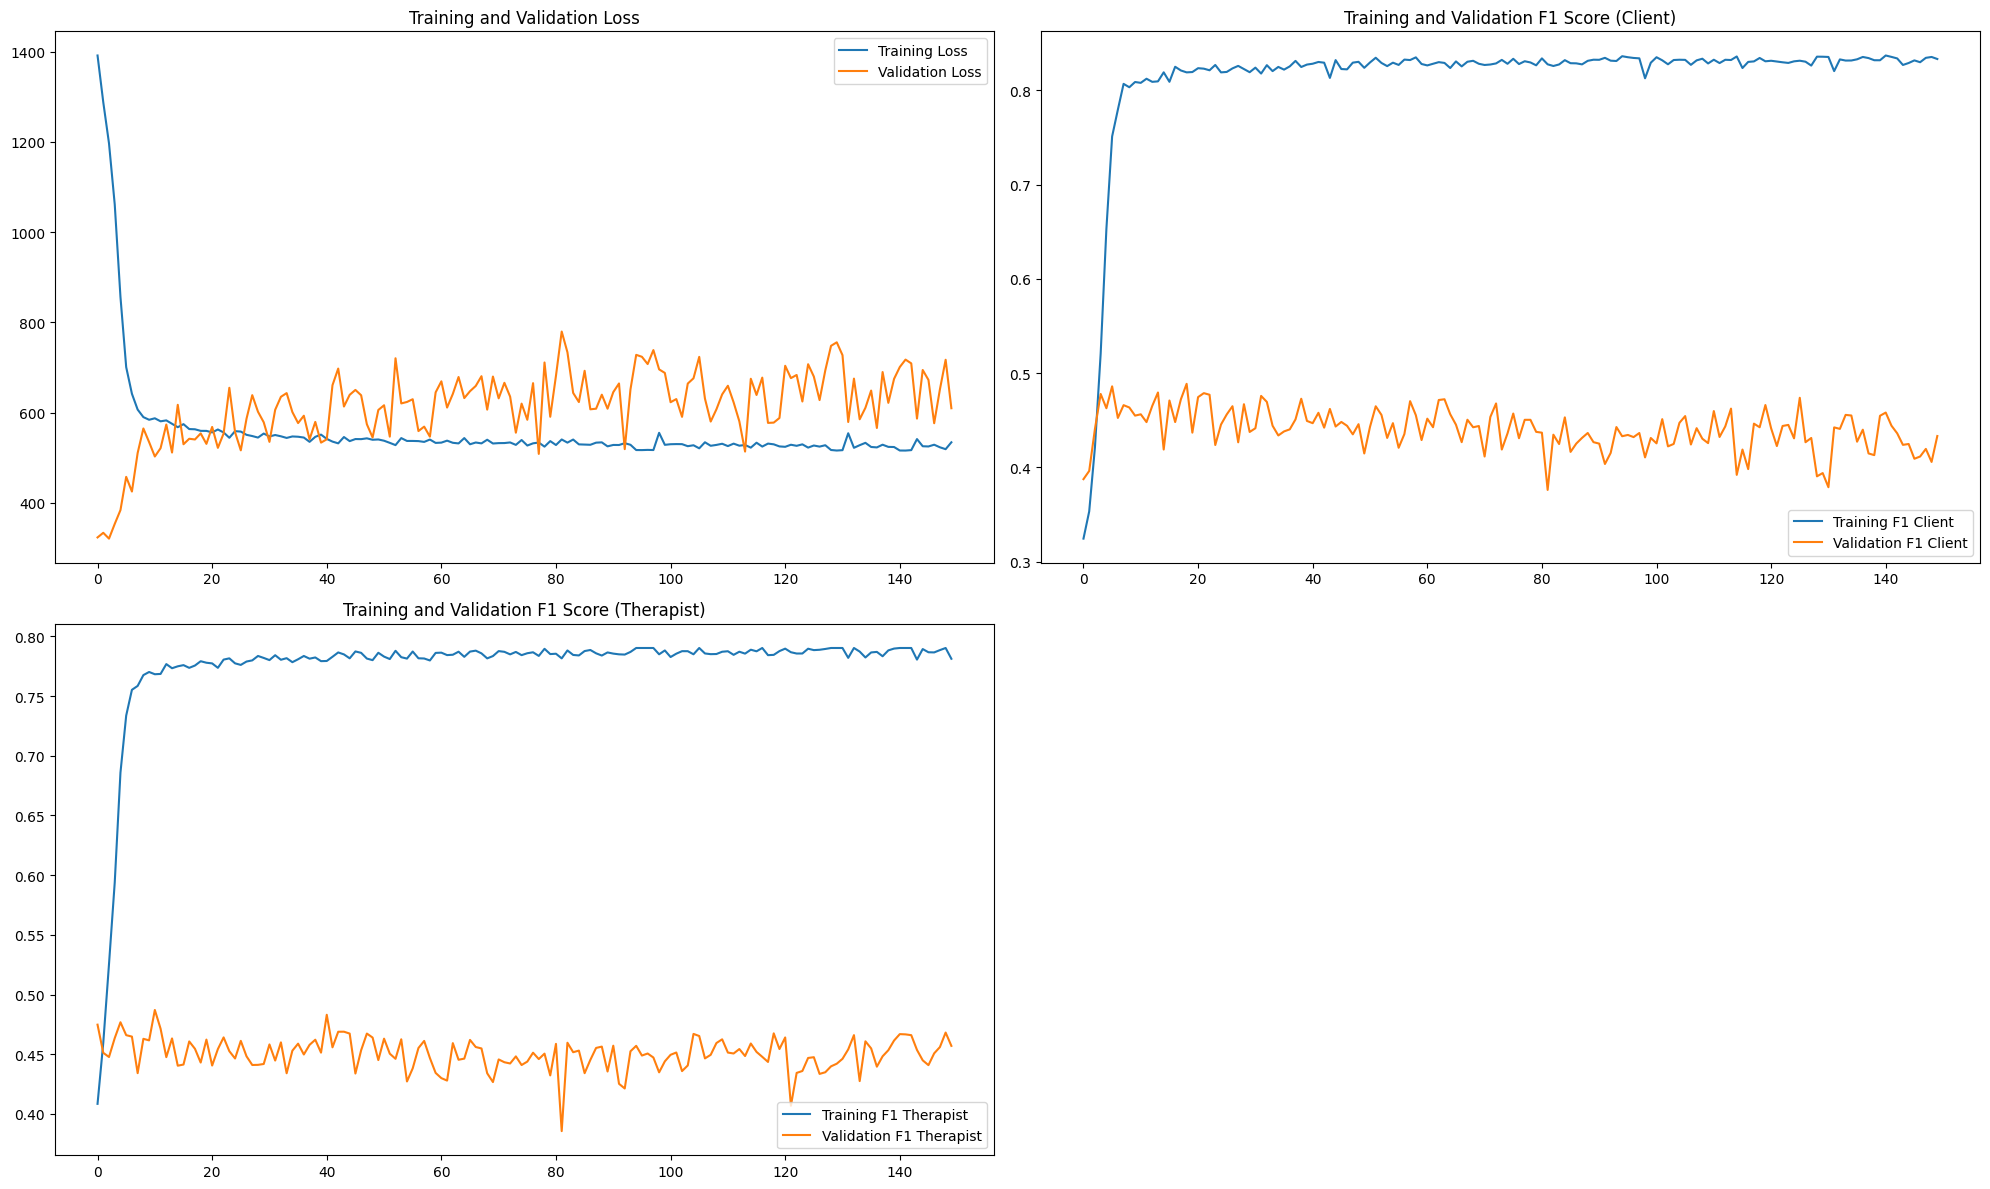

In [13]:
epochs_range = range(epochs)

plt.figure(figsize=(20, 12))

# Plot training and validation loss
plt.subplot(2, 2, 1)
plt.plot(epochs_range, training_losses, label='Training Loss')
plt.plot(epochs_range, validation_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Plot training and validation F1 scores for Client
plt.subplot(2, 2, 2)
plt.plot(epochs_range, training_f1_scores_client, label='Training F1 Client')
plt.plot(epochs_range, validation_f1_scores_client, label='Validation F1 Client')
plt.legend(loc='lower right')
plt.title('Training and Validation F1 Score (Client)')

# Plot training and validation F1 scores for Therapist
plt.subplot(2, 2, 3)
plt.plot(epochs_range, training_f1_scores_therapist, label='Training F1 Therapist')
plt.plot(epochs_range, validation_f1_scores_therapist, label='Validation F1 Therapist')
plt.legend(loc='lower right')
plt.title('Training and Validation F1 Score (Therapist)')

plt.tight_layout()
plt.show()

In [14]:
# Load the best model
model_client = model
model_client.load_state_dict(torch.load("best_mtl_model_audio_ast_client.pth"))
model_client.eval()

model_therapist = model
model_therapist.load_state_dict(torch.load("best_mtl_model_audio_ast_therapist.pth"))
model_therapist.eval()

# Final evaluation function
def evaluate_model(model, dataloader, task_name):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids, labels = batch['input_values'].to(device), batch['labels'].to(device)
            outputs = model(input_ids, task_name=task_name)
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

# Evaluate for both tasks
labels_client, preds_client = evaluate_model(model_client, val_loader_client, "client")
labels_therapist, preds_therapist = evaluate_model(model_therapist, val_loader_therapist, "therapist")

# For client task:
print("\nFinal Classification Report (Client):")
print(classification_report(labels_client, preds_client, target_names=client_class_names))

# For therapist task:
print("\nFinal Classification Report (Therapist):")
print(classification_report(labels_therapist, preds_therapist, target_names=therapist_class_names))



Final Classification Report (Client):
              precision    recall  f1-score   support

     neutral       0.43      0.43      0.43       332
      change       0.71      0.75      0.73       786
     sustain       0.25      0.18      0.21       150

    accuracy                           0.60      1268
   macro avg       0.46      0.45      0.46      1268
weighted avg       0.58      0.60      0.59      1268


Final Classification Report (Therapist):
                 precision    recall  f1-score   support

       question       0.57      0.85      0.68       455
therapist_input       0.58      0.41      0.48       364
     reflection       0.46      0.45      0.46       282
          other       0.50      0.25      0.33       187

       accuracy                           0.55      1288
      macro avg       0.53      0.49      0.49      1288
   weighted avg       0.54      0.55      0.52      1288

